In [1]:
import argparse
import os

import mmcv
import torch
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
from tools.fuse_conv_bn import fuse_module

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.core import wrap_fp16_model
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.models import build_detector

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/home/mislam22/miniconda3/envs/orientedreppoints/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# !pip install timm==0.4.12
# !pip install easyfsl==1.0.0
# !pip install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!python -c "import torch;print(torch.__version__)"

1.4.0


In [2]:
cfg = mmcv.Config.fromfile("configs/dota/orientedrepoints_r50_demo.py")
# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True
cfg.model.pretrained = None
cfg.data.test.test_mode = True

# build the model and load checkpoint
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, "work_dirs/orientedreppoints_r50_demo/epoch_40.pth", map_location='cpu')

if 'CLASSES' in checkpoint['meta']:
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

model = MMDataParallel(model, device_ids=[0])
model

MMDataParallel(
  (module): OrientedRepPointsDetector(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [21]:
!pip install easyfsl

  Using cached easyfsl-1.2.1-py3-none-any.whl (46 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 15.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 713.6 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0+cu100
    Uninstalling torch-1.4.0+cu100:
      Successfully uninstalled torch-1.4.0+cu100
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.4.0+cu92
    Uninstalling torchvision-0.4.0+cu92:
      Successfully uninstalled torchvision-0.4.0+cu92


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import pickle

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [4]:
model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Flatten()
model

MMDataParallel(
  (module): OrientedRepPointsDetector(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [5]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="./fsldata",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./fsldata",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, base_model: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.base_model = base_model

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support_ = self.base_model.module.backbone.forward(support_images)
#         for z in z_support_:
#             print(z.shape) 
        z_support = z_support_[-1].reshape(25, 2048)
        z_query_ = self.base_model.module.backbone.forward(query_images)
        z_query = z_query_[-1].reshape(50, 2048)
        
#         _support = self.backbone.forward(support_images)
#         z_query = self.backbone.forward(query_images)
        
        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        # return z_support
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

#ptmodel = PrototypicalNetworks(model).to(device='cpu')
ptmodel = PrototypicalNetworks(model).cuda()
ptmodel
# filename = 'finalized_model.sav'
# pickle.dump(ptmodel, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

PrototypicalNetworks(
  (base_model): MMDataParallel(
    (module): OrientedRepPointsDetector(
      (backbone): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=

In [7]:
next(ptmodel.parameters()).is_cuda

True

In [8]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

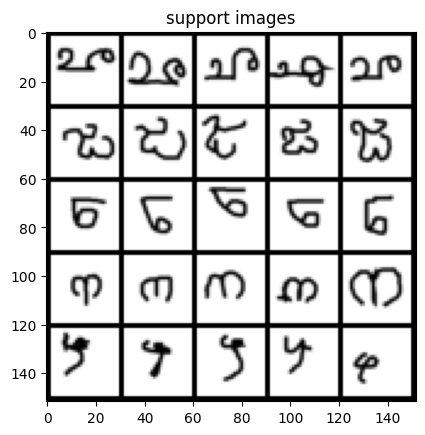

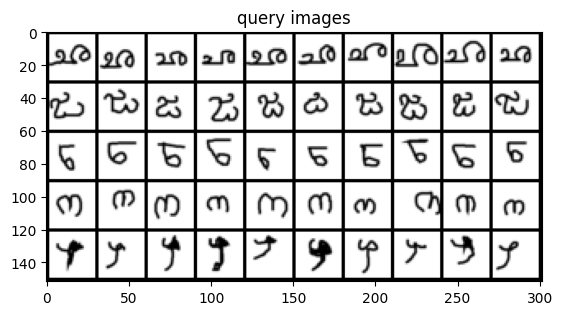

In [9]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [11]:
ptmodel.eval()
example_scores = ptmodel(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Mongolian/character15
Malayalam/character27 / Mongolian/character15
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Kannada/character19 / Kannada/character19
Kannada/character19 / Kannada/character19
Kannada/character19 / Kannada/character19
Kannada/character19 / Kannada/character19
Kannada/character19 / Kannada/character19
Kannada/character19 / Malayalam/character32
Kannada/character19 / Kannada/character19
Kannada/character19 / Kannada/character19
Kannada/character19 / Mongolian/character15
Kannada/character19 / Kannada/character19
Mongolian/character15 / Mongolian/character15
Mongolian/character15 / Malayalam/character32

In [15]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            ptmodel(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    ptmodel.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.49it/s]

Model tested on 100 tasks. Accuracy: 86.80%


In [16]:
N_TRAINING_EPISODES = 10000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=18,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ptmodel.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = ptmodel(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [20]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
ptmodel.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:05<00:00, 12.73it/s, loss=0.419]


In [21]:
evaluate(test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]

Model tested on 100 tasks. Accuracy: 95.48%
